### Imports

In [99]:
from fastai.imports import *
from fastai.structured import train_cats
import numpy as np
import pandas as pd
#df = pd.read_csv('data/transform_hot_full.csv', index_col=0)
#df = pd.read_csv('data/test_raw_df.csv', index_col=0)
df = pd.read_csv('data/transform_hot_full_shrunk.csv', index_col=0)
df.head()
#df = pd.read_csv('data/transform_hot_mini.csv', index_col=0)

,Alterac Pass,Battlefield of Eternity,Blackheart's Bay,Braxis Holdout,Cursed Hollow,Dragon Shire,Garden of Terror,Hanamura Temple,Infernal Shrines,Sky Temple,...,theirs_Valla,theirs_Varian,theirs_Whitemane,theirs_Xul,theirs_Yrel,theirs_Zagara,theirs_Zarya,theirs_Zeratul,theirs_Zul'jin,outcome
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Helper functions

In [100]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
map_names = [n for x, n, in m_names.items()]
map_names_swapped = dict([(value, key) for key, value in m_names.items()])

h_names= pd.read_csv("exports/hero_name_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
hero_names = [n for x, n, in h_names.items()]

In [101]:
mns = [x[1] for x in list(enumerate(map_names))]
yhns = ['yours_'+x[1] for x in list(enumerate(hero_names))]
thns = ['theirs_'+x[1] for x in list(enumerate(hero_names))]
#col_names = mns+yhns+thns
col_names = df.loc[:, df.columns != 'outcome'].columns
col_names

Index(['Alterac Pass', 'Battlefield of Eternity', 'Blackheart's Bay',
       'Braxis Holdout', 'Cursed Hollow', 'Dragon Shire', 'Garden of Terror',
       'Hanamura Temple', 'Infernal Shrines', 'Sky Temple',
       ...
       'theirs_Valeera', 'theirs_Valla', 'theirs_Varian', 'theirs_Whitemane',
       'theirs_Xul', 'theirs_Yrel', 'theirs_Zagara', 'theirs_Zarya',
       'theirs_Zeratul', 'theirs_Zul'jin'],
      dtype='object', length=188)

In [102]:
tmp = df[-1:].transpose()
tmp.columns = ["data"]
print(tmp[tmp['data']==True])

                  data
Infernal Shrines  True
yours_Chromie     True
yours_Falstad     True
yours_Johanna     True
yours_Sonya       True
yours_Stukov      True
theirs_Anduin     True
theirs_Kael'thas  True
theirs_Lunara     True
theirs_Muradin    True
theirs_Varian     True


### Training

#### Prepare X and Y for train and val sets.

In [103]:
#SAMPLE_SIZE = 3000
data1 = df#.sample(n = SAMPLE_SIZE, random_state = 1, axis = 0)
train_cats(data1)

## Training many models for comparison

In [104]:
#from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
from sklearn import linear_model, ensemble, gaussian_process, naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn import model_selection
from xgboost import XGBClassifier

In [105]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(), #slow
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True), #slow
    #svm.NuSVC(probability=True), #slow
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [106]:
Target = ['outcome']
data1[Target].mean()

outcome    0.49372
dtype: float64

In [107]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
p_bar = tqdm(MLA)
row_index = 0
for alg in p_bar:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    p_bar.set_description(f'Working on "{MLA_name}"')
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[col_names], data1[Target], cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[col_names], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[col_names])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Working on "XGBClassifier": 100%|██████████| 19/19 [01:19<00:00,  4.18s/it]                


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
9,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.527648,0.504985,0.0324965,0.014501
17,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.544212,0.503385,0.0298712,0.0435914
14,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.502338,0.0203421,0.0504254
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.501169,0.0180923,0.063041
15,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.499877,0.0290856,0.00953906
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.984206,0.498031,0.0365338,0.306174
12,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.686299,0.497846,0.0230141,0.022449
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.716595,0.497785,0.0343648,0.706989
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.576078,0.496985,0.0326847,0.280839
13,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.586392,0.496492,0.0318246,0.0722509


Text(0, 0.5, 'Algorithm')

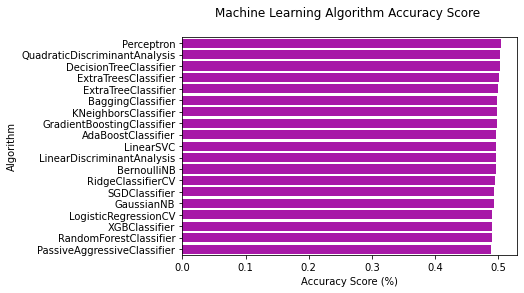

In [108]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')